# qBraid-SDK

## Unified quantum device search

There's no such function in Qiskit or Cirq, only tedious work-arounds that require you to look into the docs anyways. For Braket, it requires making an authenticated API request through Boto3, and only includes credentialed devices in the response.

The qBraid-SDK lists all available QPU's and simulators available through Qiskit, Cirq, and Braket, all in one place.

In [6]:
from qbraid import get_devices

In [7]:
get_devices(refresh=True)

Provider,Name,qBraid ID,Status
AWS,Braket Default Simulator,aws_braket_default_sim,●
AWS,Density Matrix Simulator,aws_dm_sim,●
AWS,State Vector Simulator,aws_sv_sim,●
AWS,Tensor Network Simulator,aws_tn_sim,●
D-Wave,Advantage_system4,aws_dwave_advantage_system4,●
D-Wave,DW_2000Q_6,aws_dwave_2000Q_6,●
Google,Bristlecone,google_bristlecone,○
Google,Cirq Density Matrix Simulator,google_cirq_dm_sim,●
Google,Cirq Sparse Simulator,google_cirq_sparse_sim,●
Google,Foxtail,google_foxtail,○


Filter your device search with many different advanced query options! 

For example, let's find simulators containing keyword "State" available through AWS or IBM:

In [10]:
get_devices(
    filters={
        "type": "Simulator",
        "name": {"$regex": "State"},
        "vendor": {"$in": ["AWS", "IBM"]},
    }
)

This time, let's search for all gate-based QPUs with at least 5 qubits that are online

In [25]:
get_devices(
    filters={
        "paradigm": "gate-based",
        "type": "QPU",
        "numberQubits": {"$gte": 5},
        "status": "ONLINE",
    }
)

In [26]:
# help(get_devices)  # if unsure how to construct your query

Recently added the ability to search by preferred software package, for instance

In [27]:
get_devices(filters={"runPackage": "qiskit", "requiresCred": "false"})

## The qbraid device wrapper makes running circuits easy

In [31]:
from qbraid import device_wrapper, retrieve_job
from qbraid.api import ibmq_least_busy_qpu, update_config

Copy the desired Device ID into the device wrapper function and you're on your way.

In [32]:
qbraid_device = device_wrapper("ibm_aer_qasm_sim")
qbraid_device.info

{'numberQubits': None,
 'visibility': 'public',
 'connectivityGraph': [],
 'qbraid_id': 'ibm_aer_qasm_sim',
 'name': 'Aer QASM Simulator',
 'provider': 'IBM',
 'paradigm': 'gate-based',
 'type': 'Simulator',
 'vendor': 'IBM',
 'runPackage': 'qiskit',
 'status': 'ONLINE',
 'calibrationData': [],
 'publishedStudies': [],
 'createdAt': '2022-03-10T04:08:18.968Z',
 'updatedAt': '2022-04-08T19:24:23.251Z',
 '__v': 0}

In [33]:
ibmq_least_busy_qpu()  # requires ibmq token

'ibm_q_santiago'

In [34]:
qbraid_ibmq_device = device_wrapper("ibm_q_armonk")  # requires ibmq token
qbraid_ibmq_device.info

{'numberQubits': 1,
 'visibility': 'public',
 'connectivityGraph': [],
 'qbraid_id': 'ibm_q_armonk',
 'name': 'IBMQ Armonk',
 'provider': 'IBM',
 'paradigm': 'gate-based',
 'type': 'QPU',
 'typeQubits': 'superconducting',
 'dateDeployed': '2019',
 'location': 'Armonk, NY, USA',
 'vendor': 'IBM',
 'runPackage': 'qiskit',
 'status': 'ONLINE',
 'calibrationData': [],
 'publishedStudies': [],
 'createdAt': '2022-03-10T04:08:18.469Z',
 'updatedAt': '2022-04-08T19:24:22.133Z',
 '__v': 0}

In [35]:
from qiskit import QuantumCircuit
import numpy as np

qiskit_circuit = QuantumCircuit(1, 1)

qiskit_circuit.h(0)
qiskit_circuit.ry(np.pi / 4, 0)
qiskit_circuit.rz(np.pi / 2, 0)
qiskit_circuit.measure(0, 0)

qiskit_circuit.draw()

┌───┐┌─────────┐┌─────────┐┌─┐
  q: ┤ H ├┤ Ry(π/4) ├┤ Rz(π/2) ├┤M├
     └───┘└─────────┘└─────────┘└╥┘
c: 1/════════════════════════════╩═
                                 0

Initialize quantum jobs and collect results, with the ability to extract wrapped objects at any step

In [36]:
shots = 2**10

qbraid_ibmq_job = qbraid_device.run(qiskit_circuit, shots=shots)
# qbraid_job.vendor_jlo  # vendor job-like-object

input_run_package: qiskit
device_run_package: qiskit
output_run_package: qiskit


In [38]:
qbraid_ibmq_job.status()

<JobStatus.COMPLETED: 6>

## Run your circuit on any device and compare results

In [39]:
qbraid_google_device = device_wrapper("google_cirq_dm_sim")

In [40]:
qbraid_aws_device = device_wrapper("aws_dm_sim")  # requires aws credential

In [41]:
# update_config("AWS")

In [42]:
qbraid_google_job = qbraid_google_device.run(qiskit_circuit, shots=shots)
qbraid_aws_job = qbraid_aws_device.run(qiskit_circuit, shots=shots)

input_run_package: qiskit
device_run_package: cirq
entered transpiler
output_run_package: cirq
input_run_package: qiskit
device_run_package: braket
entered transpiler
output_run_package: braket


In [43]:
qbraid_google_result = qbraid_google_job.result()
qbraid_aws_result = qbraid_aws_job.result()

In [77]:
# qbraid_ibmq_job.id

In [78]:
# ibmq_job = retrieve_job("")

In [50]:
# ibmq_job.status()

In [51]:
qbraid_ibmq_result = qbraid_ibmq_job.result()

In [52]:
print(f"google simulator counts: {qbraid_google_result.measurement_counts()}")
print(f"aws simulator counts: {qbraid_aws_result.measurement_counts()}")
print(f"ibmq qpu counts: {qbraid_ibmq_result.measurement_counts()}")

google simulator counts: {'1': 839, '0': 185}
aws simulator counts: {'1': 869, '0': 155}
ibmq qpu counts: {'1': 875, '0': 149}


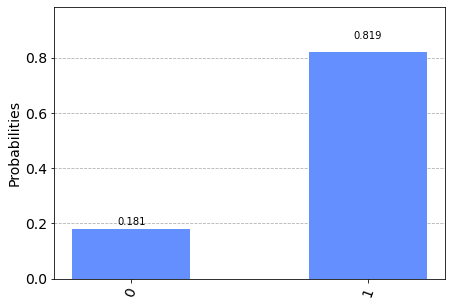

In [53]:
qbraid_google_result.plot_counts()

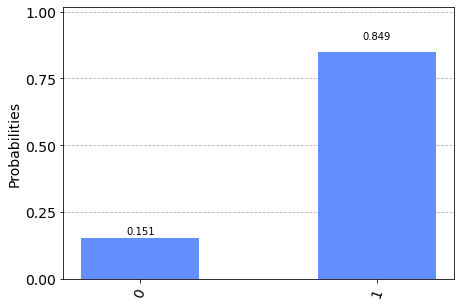

In [54]:
qbraid_aws_result.plot_counts()

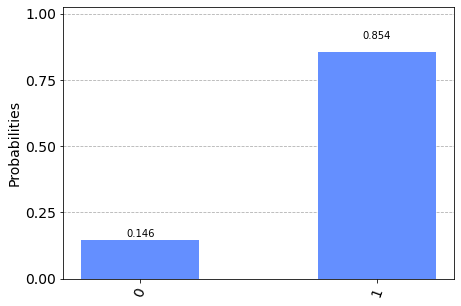

In [55]:
qbraid_ibmq_result.plot_counts()

## Utility functions to make your work easier

#### Generate random circuits in any package for testing

In [57]:
from qbraid.interface import random_circuit

In [58]:
for pkg in ["cirq", "braket", "qiskit"]:
    rand_circuit = random_circuit(pkg, num_qubits=2, depth=4)
    print(f"\n{pkg} random circuit:\n")
    print(rand_circuit)


cirq random circuit:

0: ───Y───────iSwap───────
              │
1: ───────Y───iSwap───Z───

braket random circuit:

T  : |  0  |1|2|3|
                  
q0 : -ISWAP-T-Y-C-
      |         | 
q1 : -ISWAP-----X-

T  : |  0  |1|2|3|

qiskit random circuit:

      ┌───┐     ┌───┐     ┌───┐┌───┐
q_0: ─┤ X ├─────┤ I ├─────┤ Y ├┤ Y ├
     ┌┴───┴┐┌───┴───┴────┐└─┬─┘└─┬─┘
q_1: ┤ Sdg ├┤ Rx(4.2612) ├──■────■──
     └─────┘└────────────┘          


#### Transpile circuits between packages

In [59]:
import cirq
from qbraid import circuit_wrapper

In [60]:
qs = cirq.LineQubit.range(3)
# qs.reverse()
(
    q0,
    q1,
    q2,
) = qs

cirq_circuit = cirq.Circuit(
    cirq.H(q0),
    cirq.H(q1),
    cirq.H(q2),
    cirq.X(q0),
    cirq.Y(q1),
    cirq.T(q2),
    cirq.ry(rads=np.pi / 2)(q0),
    cirq.CNOT(q1, q2),
    cirq.rz(rads=3 * np.pi / 4)(q2),
    cirq.XPowGate(exponent=0.5)(q0),
    cirq.ZPowGate(exponent=-0.5)(q1),
    cirq.SWAP(q0, q2),
    cirq.CNOT(q0, q1),
)

print(cirq_circuit)

0: ───H───X───Ry(0.5π)───X^0.5───────×───@───
                                     │   │
1: ───H───Y───@──────────S^-1────────┼───X───
              │                      │
2: ───H───T───X──────────Rz(0.75π)───×───────


In [61]:
qbraid_circuit = circuit_wrapper(cirq_circuit)

In [62]:
braket_circuit = qbraid_circuit.transpile("braket")
print(braket_circuit)

T  : |0|1|   2    |   3    | 4  |5|
                                   
q0 : -H-T-X--------Rz(2.36)-SWAP---
          |                 |      
q1 : -H-Y-C--------Si-------|----X-
                            |    | 
q2 : -H-X-Ry(1.57)-V--------SWAP-C-

T  : |0|1|   2    |   3    | 4  |5|


In [63]:
qiskit_circuit = qbraid_circuit.transpile("qiskit")
print(qiskit_circuit)

     ┌───┐┌───┐   ┌───┐   ┌──────────┐        
q_0: ┤ H ├┤ T ├───┤ X ├───┤ Rz(3π/4) ├─X──────
     ├───┤├───┤   └─┬─┘   └─┬─────┬──┘ │ ┌───┐
q_1: ┤ H ├┤ Y ├─────■───────┤ Sdg ├────┼─┤ X ├
     ├───┤├───┤┌─────────┐  └┬────┤    │ └─┬─┘
q_2: ┤ H ├┤ X ├┤ Ry(π/2) ├───┤ √X ├────X───■──
     └───┘└───┘└─────────┘   └────┘           


#### Calculate the unitary of any circuit with a single command

In [65]:
from qbraid.interface import to_unitary

In [66]:
cirq_unitary = to_unitary(cirq_circuit)
braket_unitary = to_unitary(braket_circuit)
qiskit_unitary = to_unitary(qiskit_circuit)

In [67]:
np.allclose(cirq_unitary, braket_unitary)

True

In [68]:
np.allclose(cirq_unitary, qiskit_unitary)

True

#### Patch runtime issues on the fly

In [70]:
from braket import circuits as braket_circuits
from qbraid.interface import convert_to_contiguous

In [71]:
braket_test_circuit = braket_circuits.Circuit()
braket_test_circuit.h(0)
braket_test_circuit.cnot(0, 2)
braket_test_circuit.cnot(2, 4)

Circuit('instructions': [Instruction('operator': H('qubit_count': 1), 'target': QubitSet([Qubit(0)])), Instruction('operator': CNot('qubit_count': 2), 'target': QubitSet([Qubit(0), Qubit(2)])), Instruction('operator': CNot('qubit_count': 2), 'target': QubitSet([Qubit(2), Qubit(4)]))])

In [72]:
qbraid_braket_sim = device_wrapper("aws_braket_default_sim")

In [74]:
# qbraid_braket_sim.run(braket_test_circuit, shots=shots)

In [75]:
braket_contig_circuit = convert_to_contiguous(braket_test_circuit)

In [76]:
qbraid_braket_sim.run(braket_contig_circuit, shots=shots).result().measurements()

input_run_package: braket
device_run_package: braket
output_run_package: braket


array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       ...,
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1]])

#### And more coming soon!